In [1]:
# auto reload

%load_ext autoreload
%autoreload 2

In [2]:
from dsd import DATA_DIR
from dsd.diffusion_rendering import *
from dsd.cropped_diffusion_rendering import *

/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an e

In [36]:
image_dir = DATA_DIR / "renders/mugs/objaverse-filtered-2500/84f617a1db9d48bb8521a78b6c80b8a1/011"
input_images = DiffusionRenderInputImages.from_render_dir(image_dir)
#input_images.depth_image[input_images.depth_image > 1.0] = 1.0


In [7]:
import matplotlib.pyplot as plt
def visualize_results(images):
    # plot original image and depth, as well as the processed images
    fig, axes = plt.subplots(4,4, figsize=(20, 20))
    axes = axes.flatten()
    for i, image in enumerate(images):
        ax = axes[i]
        ax.imshow(np.array(image))
    plt.show()

In [8]:
strength = 1.0
controlnet_conditioning_scale = 1.5
n_steps = 50

In [9]:
renderer = ControlNetFromDepthRenderer(num_images_per_prompt=2,num_inference_steps=n_steps,controlnet_conditioning_scale=controlnet_conditioning_scale,strength=strength)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
cropped_renderer = CroppedRenderer(renderer,only_change_mask=False)

In [12]:
#inpainter = SD2NormalCheckpointInpaintRenderer(num_images_per_prompt=4, num_inference_steps=n_steps, strength = 1.0)
inpainter = SD2InpaintingRenderer(num_images_per_prompt=2, num_inference_steps=n_steps, strength = 1.0)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
crop_and_inpaint_renderer = CropAndInpaintRenderer(cropped_renderer, inpainter,mask_dilation_iterations=3)

In [37]:
prompt = "A Smooth porcelain mug with a photorealistic wildlife illustration "
background_prompt = "on a table with legs made of stacked tires, natural light, RAW"

In [38]:

s2_images = crop_and_inpaint_renderer(prompt, background_prompt, input_images)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

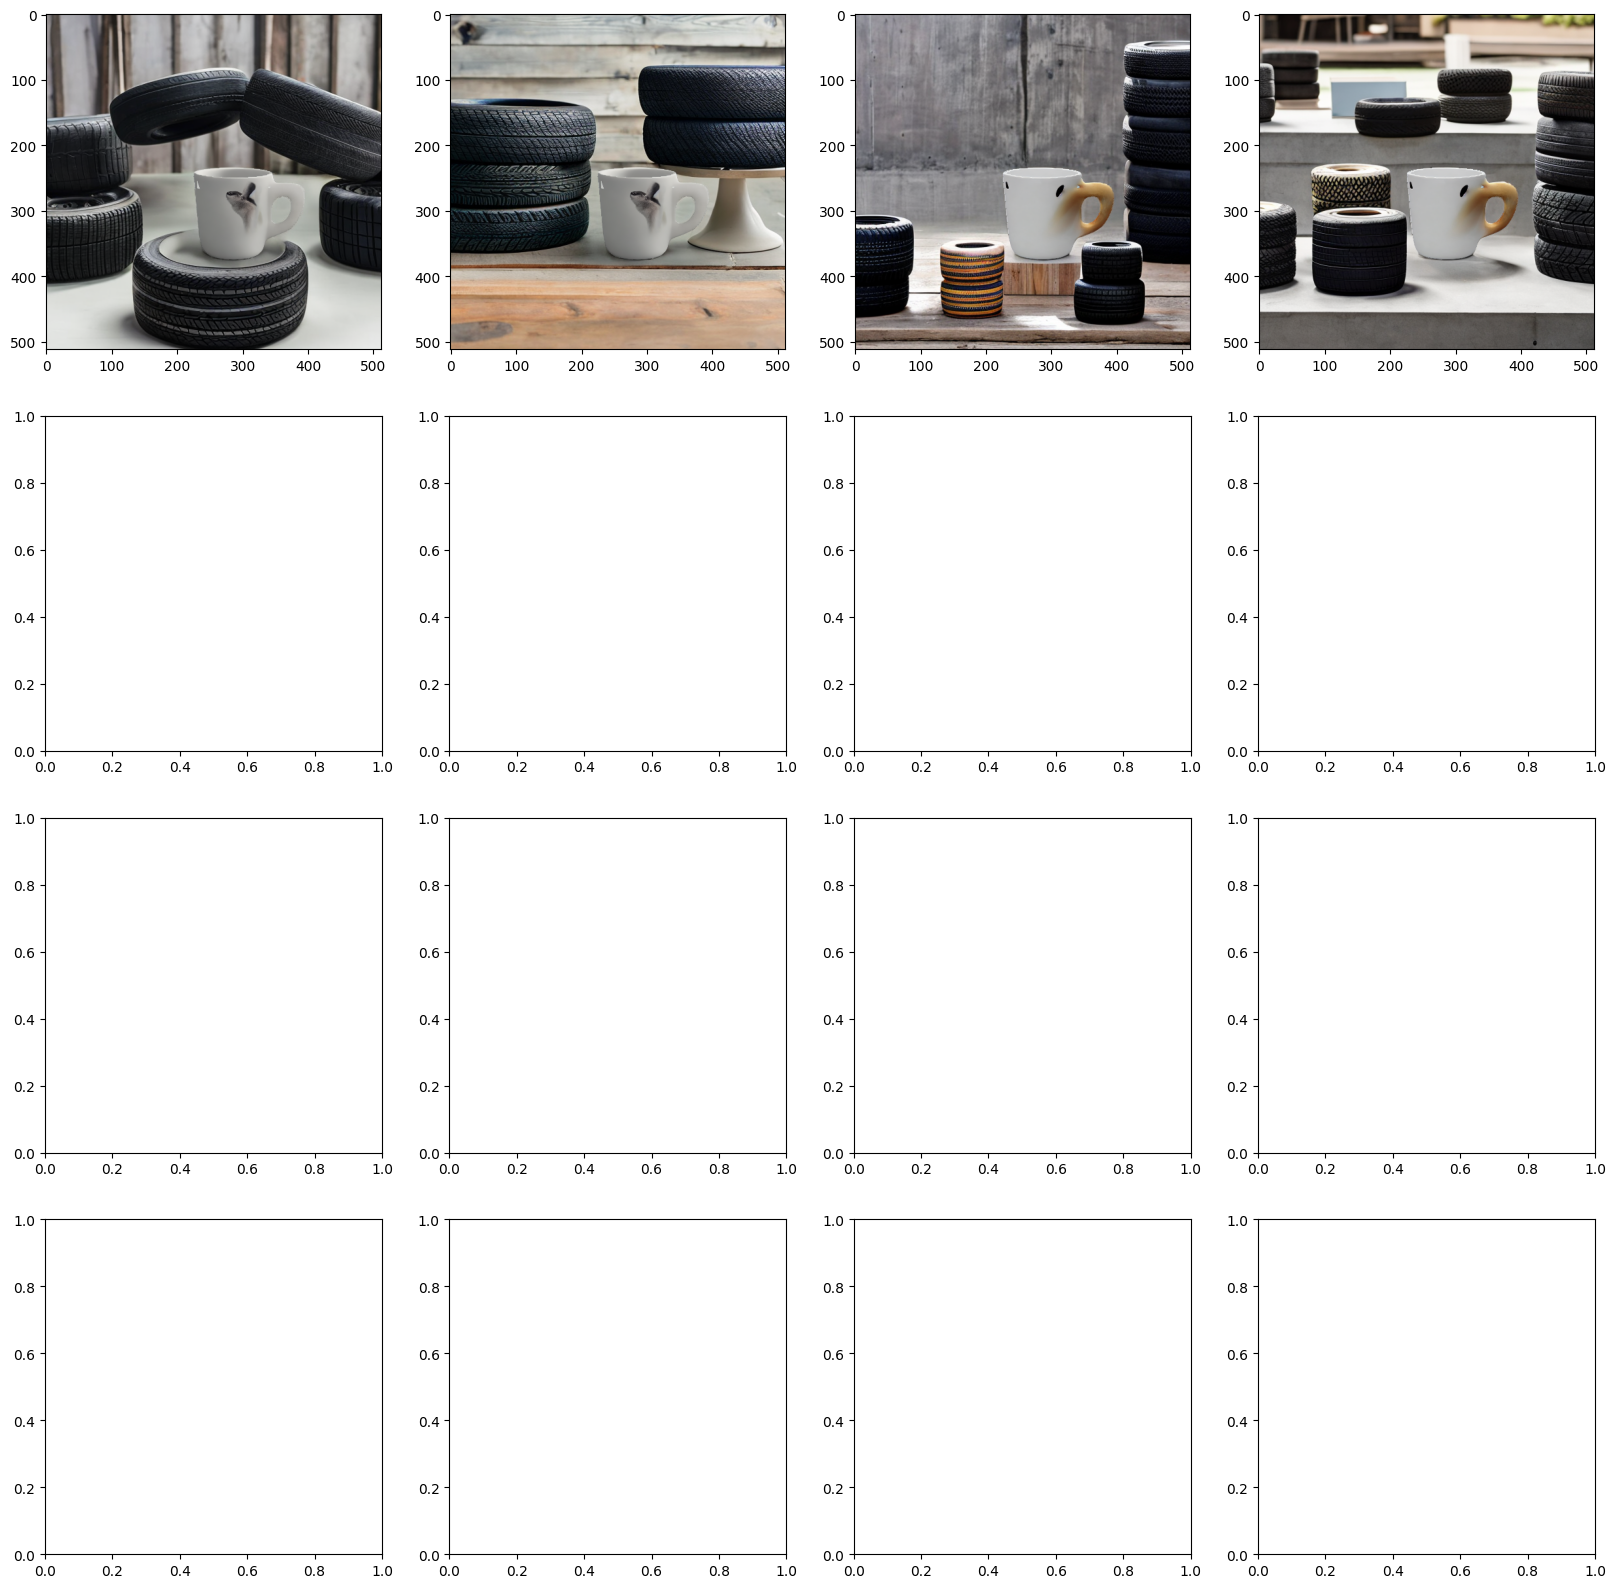

In [39]:
visualize_results(s2_images)

In [35]:
s2_images[0].save(f"2-stage_{prompt}+{background_prompt}.png")